In [1]:
import sys
sys.path.append("..")
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.spatial.distance import squareform,pdist
from numpy.linalg import norm
from sklearn.neighbors import KernelDensity

from matplotlib import cm
from matplotlib.patches import Circle

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

import models
from models import InvertibleNN
from EI_calculation import approx_ei
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0') if use_cuda else torch.device('cpu')

In [14]:
# NIS+ main model framework, using a multistory structure of the complete NIS+ framework. 

# In this structure, the encoders and decoders are stacked, and the dynamics learners in different layers operate in parallel. 

# This design facilitates simultaneous training for different dynamics learners with distinct dimensions and enables parallel searching for the optimal dimension q.

class Parellel_Renorm_Dynamic(nn.Module):
    def __init__(self, sym_size, latent_size, effect_size, cut_size, hidden_units,normalized_state,device,is_random=False):
        #latent_size: input size
        #effect_size: scale, effective latent dynamics size
        super(Parellel_Renorm_Dynamic, self).__init__()
        if latent_size < 1 or latent_size > sym_size:
            print('Latent Size is too small(<1) or too large(>input_size):', latent_size)
            raise
            return
        
        self.device = device
        self.latent_size = latent_size
        self.effect_size = effect_size
        self.sym_size = sym_size
        i = sym_size
        flows = []
        dynamics_modules = []
        inverse_dynamics_modules = []
        
        while i > latent_size:    
            input_size = max(latent_size, i)
            if i == sym_size:
                mid_size = sym_size
                dynamics = self.build_dynamics(mid_size, hidden_units)
                dynamics_modules.append(dynamics)
                inverse_dynamics = self.build_dynamics(mid_size, hidden_units)
                inverse_dynamics_modules.append(inverse_dynamics)
                flow = self.build_flow(input_size, hidden_units)
                flows.append(flow)
            
            flow = self.build_flow(input_size, hidden_units)
            flows.append(flow)
            mid_size = max(latent_size, i // cut_size)
            dynamics = self.build_dynamics(mid_size, hidden_units)
            dynamics_modules.append(dynamics)
            inverse_dynamics = self.build_dynamics(mid_size, hidden_units)
            inverse_dynamics_modules.append(inverse_dynamics)
            i = i // cut_size
        self.flows = nn.ModuleList(flows)
        self.dynamics_modules = nn.ModuleList(dynamics_modules)
        self.inverse_dynamics_modules = nn.ModuleList(inverse_dynamics_modules)

        self.normalized_state=normalized_state
        self.is_random = is_random
    def build_flow(self, input_size, hidden_units):
        if input_size % 2 !=0 and input_size > 1:
            input_size = input_size - 1
        nets = lambda: nn.Sequential(nn.Linear(input_size, hidden_units), nn.LeakyReLU(), 
                                     nn.Linear(hidden_units, hidden_units), nn.LeakyReLU(), 
                                     nn.Linear(hidden_units, input_size), nn.Tanh())
        nett = lambda: nn.Sequential(nn.Linear(input_size, hidden_units), nn.LeakyReLU(), 
                                     nn.Linear(hidden_units, hidden_units), nn.LeakyReLU(), 
                                     nn.Linear(hidden_units, input_size))

        mask1 = torch.cat((torch.zeros(1, input_size // 2, device=self.device), 
                           torch.ones(1, input_size // 2, device=self.device)), 1)
        mask2 = 1 - mask1
        masks = torch.cat((mask1, mask2, mask1, mask2, mask1, mask2), 0)
        flow = InvertibleNN(nets, nett, masks, self.device)
        return flow
    def build_dynamics(self, mid_size, hidden_units):
        dynamics = nn.Sequential(nn.Linear(mid_size, hidden_units), nn.LeakyReLU(), 
                                     nn.Linear(hidden_units, hidden_units), nn.LeakyReLU(), 
                                     nn.Linear(hidden_units, mid_size))
        return dynamics
        
    def forward(self, x):
        #state_dim = x.size()[1]
        
        if len(x.size())<=1:
            x = x.unsqueeze(0)
        ss = self.encoding(x)
        
        s_nexts = []
        ys = []
        for i,s in enumerate(ss):
            s_next = self.dynamics_modules[i](s) + s
            if self.normalized_state:
                s_next = torch.tanh(s_next)
            if self.is_random:
                s_next = s_next + torch.relu(self.sigmas.repeat(s_next.size()[0],1)) * torch.randn(s_next.size(),
                                                                                                   device=self.device)
            if i > 0:
                y = self.decoding(s_next, i)
            else:
                y = s_next
            s_nexts.append(s_next)
            ys.append(y)
        return ys, ss, s_nexts
    def back_forward(self, x):
        #state_dim = x.size()[1]
        
        if len(x.size())<=1:
            x = x.unsqueeze(0)
        ss = self.encoding(x)
        
        s_nexts = []
        ys = []
        for i,s in enumerate(ss):
            s_next = self.inverse_dynamics_modules[i](s) - s
            if self.normalized_state:
                s_next = torch.tanh(s_next)
            if self.is_random:
                s_next = s_next + torch.relu(self.sigmas.repeat(s_next.size()[0],1)) * torch.randn(s_next.size(),
                                                                                                   device=self.device)
            if i > 0:
                y = self.decoding(s_next, i)
            else:
                y = s_next
            s_nexts.append(s_next)
            ys.append(y)
        return ys, ss, s_nexts
    def back_forward_1layer(self, x, level):
        #state_dim = x.size()[1]
        
        if len(x.size())<=1:
            x = x.unsqueeze(0)
        ss = self.encoding(x)
        
        s=ss[level]
        
        s_next = self.inverse_dynamics_modules[level](s) - s
        if self.normalized_state:
            s_next = torch.tanh(s_next)
        if self.is_random:
            s_next = s_next + torch.relu(self.sigmas.repeat(s_next.size()[0],1)) * torch.randn(s_next.size(),
                                                                                                device=self.device)
        if level > 0:
            y = self.decoding(s_next, level)
        else:
            y = s_next
    
        return y, ss, s_next
    def decoding(self, s_next, level):
        y = s_next
        for i in range(level+1)[::-1]:
            flow = self.flows[i]
            end_size = self.latent_size
            if i < len(self.flows)-1:
                flow_n = self.flows[i+1]
                end_size = max(y.size()[1], flow_n.size)
            #print(flow.size, end_size, y.size()[1])
            sz = flow.size - end_size
            
            if sz>0:
                noise = distributions.MultivariateNormal(torch.zeros(sz), torch.eye(sz)).sample((y.size()[0], 1))
                noise = noise.to(self.device)
                #print(noise.size(), s_next.size(1))
                if y.size()[0]>1:
                    noise = noise.squeeze(1)
                else:
                    noise = noise.squeeze(0)
                y = torch.cat((y, noise), 1)
            y,_ = flow.g(y)
        return y
    def decoding1(self, s_next, level):
        y = s_next
        for i in range(level+1)[::-1]:
            flow = self.flows[i]
            end_size = self.latent_size
            if i < len(self.flows)-1:
                flow_n = self.flows[i+1]
                end_size = max(y.size()[1], flow_n.size)
            #print(flow.size, end_size, y.size()[1])
            sz = flow.size - end_size
            
            if sz>0:
                noise = distributions.MultivariateNormal(torch.zeros(sz), torch.eye(sz)).sample((y.size()[0], 1))
                noise = noise.to(self.device)
                #print(noise.size(), s_next.size(1))
                if y.size()[0]>1:
                    noise = noise.squeeze(1)
                else:
                    noise = noise.squeeze(0)
                y = torch.cat((y, noise), 1)
            y,_ = flow.g(y)
        return y
    def encoding(self, x):
        xx = x
        if len(x.size()) > 1:
            if x.size()[1] < self.sym_size:
                xx = torch.cat((x, torch.zeros([x.size()[0], self.sym_size - x.size()[1]], device=self.device)), 1)
        else:
            if x.size()[0] < self.sym_size:
                xx = torch.cat((x, torch.zeros([self.sym_size - x.size()[0]], device=self.device)), 0)
        y = xx
        ys = []
        for i,flow in enumerate(self.flows):
            if y.size()[1] > flow.size:
                #y = torch.cat((y, y[:,:1]), 1)
                y = y[:, :flow.size]
            y,_ = flow.f(y)
            if self.normalized_state:
                y = torch.tanh(y)
            pdict = dict(self.dynamics_modules[i].named_parameters())
            lsize = pdict['0.weight'].size()[1]
            y = y[:, :lsize]
            ys.append(y)
        return ys
    def encoding1(self, x):
        xx = x
        if len(x.size()) > 1:
            if x.size()[1] < self.sym_size:
                xx = torch.cat((x, torch.zeros([x.size()[0], self.sym_size - x.size()[1]], device=self.device)), 1)
        else:
            if x.size()[0] < self.sym_size:
                xx = torch.cat((x, torch.zeros([self.sym_size - x.size()[0]], device=self.device)), 0)
        y = xx
        ys = []
        for i,flow in enumerate(self.flows):
            if y.size()[1] > flow.size:
                #y = torch.cat((y, y[:,:1]), 1)
                y = y[:, :flow.size]
            y,_ = flow.f(y)
            if self.normalized_state:
                y = torch.tanh(y)
            pdict = dict(self.inverse_dynamics_modules[i].named_parameters())
            lsize = pdict['0.weight'].size()[1]
            y = y[:, :lsize]
            ys.append(y)
        return ys
    def loss(self, predictions, real, loss_f):
        losses = []
        sum_loss = 0
        for i, predict in enumerate(predictions):
            loss = loss_f(real, predict)
            losses.append(loss)
            sum_loss += loss
        return losses, sum_loss / len(predictions)
    def loss_weights(self, predictions, real, weightss,loss_f,level):
        losses = []
        sum_loss = 0
        for i, predict in enumerate(predictions):
            if i==level:
                w=weightss[0]
                loss = (loss_f(real, predict)*w).mean([0,1])
            else:
                loss = loss_f(real, predict).mean([0,1])
            losses.append(loss)
            sum_loss += loss
        return losses, sum_loss / len(predictions)
    def loss_weights_back_1layer(self,latents,latent_p0,predictions, real,weightss, loss_f,level=3,lam=1):
            
        w=weightss[0]
        loss = (loss_f(latents[level], latent_p0)*w).mean([0,1])+lam*loss_f(real, predictions[level]).mean([0,1])
            
        return loss
    def loss_weights_back(self, latents,latent_ps0,predictions, real,weightss, loss_f,level=3,lam=1):
        losses = []
        sum_loss = 0
        for i, predict in enumerate(predictions):
            if i==level:
                w=weightss[0]
                loss = (loss_f(latents[i],latent_ps0[i])*w).mean([0,1])+lam*loss_f(real, predict).mean([0,1])
            else:
                loss = loss_f(real, predict).mean([0,1])
            losses.append(loss)
            sum_loss += loss
        return losses, sum_loss / len(predictions)
    def calc_EIs(self, real, latent_ps, device):
        sp = self.encoding(real)
        eis = []
        sigmass = []
        scales = []
        for i,state in enumerate(sp):
            latent_p = latent_ps[i]
            flow = self.flows[i]
            dynamics = self.dynamics_modules[i]
            dd = dict(dynamics.named_parameters())
            scale = dd['0.weight'].size()[1]
            
            sigmas = torch.sqrt(torch.mean((state-latent_p)**2, 0))
            sigmas_matrix = torch.diag(sigmas)
            ei = approx_ei(scale, scale, sigmas_matrix.data, lambda x:(dynamics(x.unsqueeze(0))+x.unsqueeze(0)), 
                           num_samples = 1000, L=100, easy=True, device=device)
            eis.append(ei)
            sigmass.append(sigmas)
            scales.append(scale)
        return eis, sigmass, scales
    
    def to_weights(self,log_w, temperature=10):  #？重加权应该是个优化模型
        #将log_w做softmax归一化，得到权重
        logsoft = nn.LogSoftmax(dim = 0)
        weights = torch.exp(logsoft(log_w/temperature))
        return weights
    def kde_density(self,X):
        is_cuda = X.is_cuda  #True为储存在GPU
        ldev = X.device  #分配内存在哪里运行
        dim = X.size()[1] #获取数据的列数即维数
        # kde = KernelDensity(kernel='gaussian', bandwidth=0.1, atol=0.005).fit(X.cpu().data.numpy())
        kde = KernelDensity(kernel='gaussian', bandwidth=0.05, atol=0.2).fit(X.cpu().data.numpy())
        log_density = kde.score_samples(X.cpu().data.numpy())
        return log_density, kde
    def calc_EIs_ked(self,s,sp,lp,samples,MAE_raw,L,bigL,level,device):
        #spring_data生成方式：spring_data = spring.generate_multistep(size=1000, steps=10, sigma=sigma, lam=1,miu=0.5)，为多步数据，样本点等于size*steps
        #samples跟spring_data样本点数一样，数越大运算会越慢，主要是kde估计很耗时间
        #MAE_raw = torch.nn.L1Loss(reduction='none')
        #L=bigL,根据隐空间范围进行调试，要保证能覆盖隐空间同时尽可能小
        
        encodes=self.encoding(sp)
        predicts1, latent1s, latentp1s = self.forward(s)
        eis=[]
        sigmass = []
        weightss=[]
        for index in range(len(predicts1)):
            if index==level:
                sigmas_matrix=torch.zeros([2,2],device=device)
                dynamics = self.dynamics_modules[index]
                latent1=latent1s[index]
                latentp1=latentp1s[index]
                scale=len(latent1[0])
                encode=encodes[index]

                log_density, k_model_n = self.kde_density(latent1)
                log_rho = - scale * torch.log(2.0*torch.from_numpy(np.array(L)))  #均匀分布的概率分布
                logp = log_rho - log_density  #两种概率分布的差
                weights = self.to_weights(logp, temperature=1) * samples
                if use_cuda:
                    weights = weights.cuda(device=device)
                weights=weights.unsqueeze(1)
                
                mae1 = MAE(latentp1, encode) * torch.cat([weights for i in range(scale)],1) 
                #mae1 = MAE_raw(torch.cat([latentp1 for i in range(len(latent1s[0][0]))],0), encode) * torch.cat(
                #    [torch.cat([weights for i in range(scale)],1) for j in range(len(latent1s[0][0]))],0)  
                    #两维的情况，根据维度情况需要调整，weights的多维直接copy就行
                sigmas=mae1.mean(axis=0)
                
                sigmas_matrix = torch.diag(sigmas)
                ei = approx_ei(scale, scale, sigmas_matrix.data, lambda x:(dynamics(x.unsqueeze(0))+x.unsqueeze(0)), 
                            num_samples = 1000, L=bigL, easy=True, device=device)  #approx_ei函数本身没有变化
        
                eis.append(ei)
                sigmass.append(sigmas)
                weightss.append(weights)
            else:
                latent_p = lp[index]
                flow = self.flows[index]
                dynamics = self.dynamics_modules[index]
                dd = dict(dynamics.named_parameters())
                scale = dd['0.weight'].size()[1]
                
                sigmas = torch.sqrt(torch.mean((encodes[index]-latent_p)**2, 0))
                sigmas_matrix = torch.diag(sigmas)
                ei = approx_ei(scale, scale, sigmas_matrix.data, lambda x:(dynamics(x.unsqueeze(0))+x.unsqueeze(0)), 
                            num_samples = 1000, L=100, easy=True, device=device)
                eis.append(ei)
                sigmass.append(sigmas)
                #scales.append(scale)
        return eis, sigmass,weightss
     
    def eff_predict(self, prediction):
        return prediction[:, :self.effect_size]
    def simulate(self, x, level):
        if level > len(self.dynamics_modules) or level<0:
            print('input error: level must be less than', len(self.dynamics_modules))
        dynamics = self.dynamics_modules[level]
        x_next = dynamics(x) + x
        decode = self.decoding(x_next, level)
        return x_next, decode
    def multi_step_prediction(self, s, steps, level):
        if level > len(self.dynamics_modules) or level<0:
            print('input error: level must be less than', len(self.dynamics_modules))
        s_hist = s
        ss = self.encoding(s)
        z_hist = ss[level]
        z = z_hist[:1, :]
        for t in range(steps):    
            z_next, s_next = self.simulate(z, level)
            z_hist = torch.cat((z_hist, z_next), 0)
            s_hist = torch.cat((s_hist, self.eff_predict(s_next)), 0)
            z = z_next
        return s_hist, z_hist
    def multi_step_prediction_0(self, s, steps, level):
        if level > len(self.dynamics_modules) or level<0:
            print('input error: level must be less than', len(self.dynamics_modules))
        predicts=[]
        latents=[]
        s_hist = s
        ss = self.encoding(s)
        z_hist = ss[level]
        z = z_hist[:, :]
        predicts.append(s)
        latents.append(z)
        for t in range(steps):    
            z_next, s_next = self.simulate(z, level)
            z_hist = torch.cat((z_hist, z_next), 0)
            s_hist = torch.cat((s_hist, self.eff_predict(s_next)), 0)
            predicts.append(s_next)
            latents.append(z_next)
            z = z_next
        return predicts, latents

In [3]:
width, height, init_w = 300,300, 5

class Boids1:
    '''initialize the boids simulation'''
    def __init__(self,N):
        #initialize the boid simulation, in 4 groups
        self.pos =init_w*np.random.rand(2*N).reshape(N,2)
        #init_center = np.array([[width//4, height//4],
        #                        [width//4, height*3//4],
        #                       [width*3//4, height//4],
        #                       [width*3//4, height*3//4]])
        init_center = np.array([[width//2-width//150, height//2]])
        #init_center=height*np.random.rand(2*4).reshape(4,2)
        for i in range(1):
            self.pos[N*i//1:N*(i+1)//1] += init_center[i] 
        #self.angles = 2*math.pi*np.array([np.random.rand() for i in range(N)])
        self.angles = 2*math.pi*np.array([1/2 for i in range(N)])
        angles= self.angles
        #angles = 2*math.pi*np.array([1/8 for i in range(N)])
        self.vel = np.array(list(zip(np.sin(angles),np.cos(angles))))
        self.N=N
#控制速度恒定为2
        self.velFix = 1.0 
#排斥和内聚（以及平行）的检测距离        
        self.minDist =1
        self.maxDist = 80
        self.sepDist = 180
#平行，排斥，内聚, 群排斥速度的权重
        self.al = 1.0
        self.se = 1.0
        self.co = 1.0
        self.se2 = 0.5
        self.bumper = 0.3
        self.maxRuleVel = 0.5
        self.maxVel = 2.0
#噪声
        self.noise = 0.2
#平均速度和平均距离（初始设置为0）
        self.aveVel = 0
        self.aveDist = 0
        
    def move(self):
#update the simulation by one time step
#距离矩阵，使用 squareform(pdist(self.pos))能直接输出类鸟间相对距离的矩阵，输出的矩阵对角线为0且对称
        self.distMatrix = squareform(pdist(self.pos))
        self.aveDist = self.distMatrix.sum()/(self.N)**2
        #apply rules
        self.vel +=self.applyRules()
        self.fix(self.vel,self.velFix)
#加上噪声
        #angles = 2*math.pi*np.random.rand(self.N)
        angles=self.angles
        self.vel += np.array(list(zip(np.sin(angles),np.cos(angles))))*self.noise*self.velFix
        self.angles = self.angles+2*math.pi*np.array([1/256 for i in range(self.N)])
#控制速度一定
        self.fix(self.vel,self.velFix)
        self.aveVel = norm(self.vel.sum(axis=0)/self.N)
        self.pos +=self.vel
#周期边界条件
        self.applyBC()     
        
    def limitVec(self,vec,maxVal):
        #limit the magnitide of the 2D vector
        mag = norm(vec)
        #将速度换成maxVal
        if mag > maxVal:
            vec[0],vec[1] = vec[0]*maxVal/mag,vec[1]*maxVal/mag
            
    def limit(self,X,maxVal):
        #limit the magnitide of 2D vectors in array X to maxVal
        for vec in X:
            self.limitVec(vec,maxVal)
            
    def fixVec(self,vec,velFix):
        #limit the magnitide of the 2D vector
        mag = norm(vec)
#将速度换成velFix
        vec[0],vec[1] = vec[0]*velFix/mag,vec[1]*velFix/mag
            
    def fix(self,X,velFix):
        #limit the magnitide of 2D vectors in array X to maxVal
        for vec in X:
            self.fixVec(vec,velFix)
            
    def applyBC(self):
        #apply boundary conditions
        deltaR = 5
        for i in range(len(self.pos)):
            coord = self.pos[i]
            vel = self.vel[i]
            if coord[0] > width - deltaR:
                # coord[0] = -deltaR
                vel[0] -= self.bumper * self.velFix * (coord[0] + deltaR - width) / deltaR
                
            if coord[0] < deltaR:
                # coord[0] = width+deltaR
                vel[0] += self.bumper * self.velFix * (deltaR - coord[0]) / deltaR
                
            if coord[1] > height - deltaR:
                # coord[1] = -deltaR
                vel[1] -= self.bumper * self.velFix * (coord[1] + deltaR - height) / deltaR
                
            if coord[1] < deltaR:
                # coord[1] = height+deltaR
                vel[1] += self.bumper * self.velFix * (deltaR - coord[1]) / deltaR
            
    def applyRules(self):
        #rule 1:separation
        D = self.distMatrix <self.minDist
#求解质心位置，并且产生远离质心的速度
        vel = self.pos*D.sum(axis=1).reshape(self.N,1) - D.dot(self.pos)
        self.limit(vel,self.maxRuleVel)
        vel = vel*self.se
        D = self.distMatrix <self.maxDist
        #rule 2:alignment
#求范围内平均速度
        vel2 = D.dot(self.vel)
        self.limit(vel2,self.maxRuleVel)
        vel +=vel2*self.al
        #rule 3: cohesion
#朝着质心移动
        # Yuan Bing: keep the same scale as of vel1
        vel3 =D.dot(self.pos) - self.pos*D.sum(axis=1).reshape(self.N,1)#质心-自己位置
        self.limit(vel3,self.maxRuleVel)
        vel +=vel3*self.co
#远离质心移动
        D = self.distMatrix < self.sepDist
        vel4 = self.pos*D.sum(axis=1).reshape(self.N,1) - D.dot(self.pos)#自己位置-质心
        self.limit(vel4,self.maxRuleVel)
        vel +=vel4*self.se2
        self.limit(vel,self.maxRuleVel)
        return vel

In [4]:
width, height, init_w = 300,300, 5

class Boids2:
    '''initialize the boids simulation'''
    def __init__(self,N):
        #initialize the boid simulation, in 4 groups
        self.pos =init_w*np.random.rand(2*N).reshape(N,2)
        #init_center = np.array([[width//4, height//4],
        #                        [width//4, height*3//4],
        #                       [width*3//4, height//4],
        #                       [width*3//4, height*3//4]])
        init_center = np.array([[width//2+width//150, height//2]])
        #init_center=height*np.random.rand(2*4).reshape(4,2)
        for i in range(1):
            self.pos[N*i//1:N*(i+1)//1] += init_center[i] 
        #self.angles = 2*math.pi*np.array([np.random.rand() for i in range(N)])
        self.angles = -2*math.pi*np.array([1/2 for i in range(N)])
        angles= self.angles
        #angles = 2*math.pi*np.array([1/8 for i in range(N)])
        self.vel = np.array(list(zip(np.sin(angles),np.cos(angles))))
        self.N=N
#控制速度恒定为2
        self.velFix = 1.0 
#排斥和内聚（以及平行）的检测距离        
        self.minDist =1
        self.maxDist = 80
        self.sepDist = 180
#平行，排斥，内聚, 群排斥速度的权重
        self.al = 1.0
        self.se = 1.0
        self.co = 1.0
        self.se2 = 0.5
        self.bumper = 0.3
        self.maxRuleVel = 0.5
        self.maxVel = 2.0
#噪声
        self.noise = 0.2
#平均速度和平均距离（初始设置为0）
        self.aveVel = 0
        self.aveDist = 0
        
    def move(self):
#update the simulation by one time step
#距离矩阵，使用 squareform(pdist(self.pos))能直接输出类鸟间相对距离的矩阵，输出的矩阵对角线为0且对称
        self.distMatrix = squareform(pdist(self.pos))
        self.aveDist = self.distMatrix.sum()/(self.N)**2
        #apply rules
        self.vel +=self.applyRules()
        self.fix(self.vel,self.velFix)
#加上噪声
        #angles = 2*math.pi*np.random.rand(self.N)
        angles=self.angles
        self.vel += np.array(list(zip(np.sin(angles),np.cos(angles))))*self.noise*self.velFix
        self.angles = self.angles-2*math.pi*np.array([1/192 for i in range(self.N)])
#控制速度一定
        self.fix(self.vel,self.velFix)
        self.aveVel = norm(self.vel.sum(axis=0)/self.N)
        self.pos +=self.vel
#周期边界条件
        self.applyBC()     
        
    def limitVec(self,vec,maxVal):
        #limit the magnitide of the 2D vector
        mag = norm(vec)
        #将速度换成maxVal
        if mag > maxVal:
            vec[0],vec[1] = vec[0]*maxVal/mag,vec[1]*maxVal/mag
            
    def limit(self,X,maxVal):
        #limit the magnitide of 2D vectors in array X to maxVal
        for vec in X:
            self.limitVec(vec,maxVal)
            
    def fixVec(self,vec,velFix):
        #limit the magnitide of the 2D vector
        mag = norm(vec)
#将速度换成velFix
        vec[0],vec[1] = vec[0]*velFix/mag,vec[1]*velFix/mag
            
    def fix(self,X,velFix):
        #limit the magnitide of 2D vectors in array X to maxVal
        for vec in X:
            self.fixVec(vec,velFix)
            
    def applyBC(self):
        #apply boundary conditions
        deltaR = 5
        for i in range(len(self.pos)):
            coord = self.pos[i]
            vel = self.vel[i]
            if coord[0] > width - deltaR:
                # coord[0] = -deltaR
                vel[0] -= self.bumper * self.velFix * (coord[0] + deltaR - width) / deltaR
                
            if coord[0] < deltaR:
                # coord[0] = width+deltaR
                vel[0] += self.bumper * self.velFix * (deltaR - coord[0]) / deltaR
                
            if coord[1] > height - deltaR:
                # coord[1] = -deltaR
                vel[1] -= self.bumper * self.velFix * (coord[1] + deltaR - height) / deltaR
                
            if coord[1] < deltaR:
                # coord[1] = height+deltaR
                vel[1] += self.bumper * self.velFix * (deltaR - coord[1]) / deltaR
            
    def applyRules(self):
        #rule 1:separation
        D = self.distMatrix <self.minDist
#求解质心位置，并且产生远离质心的速度
        vel = self.pos*D.sum(axis=1).reshape(self.N,1) - D.dot(self.pos)
        self.limit(vel,self.maxRuleVel)
        vel = vel*self.se
        D = self.distMatrix <self.maxDist
        #rule 2:alignment
#求范围内平均速度
        vel2 = D.dot(self.vel)
        self.limit(vel2,self.maxRuleVel)
        vel +=vel2*self.al
        #rule 3: cohesion
#朝着质心移动
        # Yuan Bing: keep the same scale as of vel1
        vel3 =D.dot(self.pos) - self.pos*D.sum(axis=1).reshape(self.N,1)#质心-自己位置
        self.limit(vel3,self.maxRuleVel)
        vel +=vel3*self.co
#远离质心移动
        D = self.distMatrix < self.sepDist
        vel4 = self.pos*D.sum(axis=1).reshape(self.N,1) - D.dot(self.pos)#自己位置-质心
        self.limit(vel4,self.maxRuleVel)
        vel +=vel4*self.se2
        self.limit(vel,self.maxRuleVel)
        return vel

starting boids...


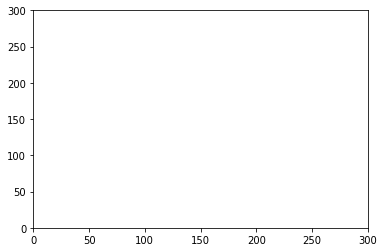

In [5]:
print('starting boids...')
#set the initial number of boids
N = 50
boids = Boids1(N)    
#set up plot
fig = plt.figure(1)
ax = plt.axes(xlim=(0,width),ylim = (0,height))
#设定身体大小为8    
pts, = plt.plot([],[],markersize =8,c='k',marker='o',ls='None')
#设定头部大小为3
beak, = plt.plot([],[],markersize = 3,c = 'r',marker='o',ls='None')
aveVels =[]
aveDists =[]
frameNums = []
def update(frameNum,boids):
    #update function for animation
    #print(frameNum)
    if frameNum%50 == 0:
        print('当前帧数{}'.format(frameNum))
        print('平均速度为{}'.format(boids.aveVel))
        aveVels.append(boids.aveVel)
        aveDists.append(boids.aveDist)
        frameNums.append(frameNum)
    boids.move()
    pts.set_data(boids.pos.reshape(2*boids.N)[::2],
                    boids.pos.reshape(2*boids.N)[1::2])
    vec = boids.pos + 4*boids.vel/boids.maxVel 
    beak.set_data(vec.reshape(2*boids.N)[::2],
                    vec.reshape(2*boids.N)[1::2])  
    plt.plot(boids.pos[0][0],boids.pos[0][1],c='y',marker=',',markersize=2)
    plt.plot(boids.pos[10][0],boids.pos[10][1],c='b',marker=',',markersize=2)
    plt.plot(boids.pos[20][0],boids.pos[20][1],c='r',marker=',',markersize=2)
    return pts,beak
plt.show()

In [6]:
def generate_data_p(boids,device):
    boids.move()
    pts.set_data(boids.pos.reshape(2*boids.N)[::2],
                    boids.pos.reshape(2*boids.N)[1::2])
    vec = boids.pos + 4*boids.vel/boids.maxVel 
    beak.set_data(vec.reshape(2*boids.N)[::2],
                    vec.reshape(2*boids.N)[1::2])  
    #plt.plot(boids.pos[0][0],boids.pos[0][1],c='y',marker=',',markersize=2)
    #plt.plot(boids.pos[10][0],boids.pos[10][1],c='b',marker=',',markersize=2)
    #plt.plot(boids.pos[20][0],boids.pos[20][1],c='r',marker=',',markersize=2)

    Pos_Vec=np.hstack((np.array(boids.pos),np.array(boids.vel)))
    Pos_Vec=torch.FloatTensor(Pos_Vec)
    Pos_Vec=Pos_Vec.to(device)
    return Pos_Vec

In [7]:
def generate_data_set(Boids1,Boids2,N1,N2,num_of_PosVec,batch_size):
    
    Pos_Vecs_data=[[] for i in range(num_of_PosVec)]
    Pos_Vecps_data=[[] for i in range(num_of_PosVec)]
    Pos_Vecs_batch=[[] for batch in range(batch_size)]
    Pos_Vecps_batch=[[] for batch in range(batch_size)]

    for batch in range(batch_size):
        Pos_Vecs=[]
        Pos_Vecps=[]
        boids1 = Boids1(N1)  
        boids2 = Boids2(N2) 
        Pos_Vec=np.vstack((np.hstack((np.array(boids1.pos),np.array(boids1.vel))),np.hstack((np.array(boids2.pos),np.array(boids2.vel)))))

        Pos_Vec=torch.FloatTensor(Pos_Vec)
        Pos_Vec=Pos_Vec.to(device)

        for origin_t in range(20):
            boids1.move()
            boids2.move()
        for t in range(num_of_PosVec):
            Pos_Vec1_p= generate_data_p(boids1,device)
            Pos_Vec2_p= generate_data_p(boids2,device)
            Pos_Vec_p=torch.cat([Pos_Vec1_p,Pos_Vec2_p], 0)
            Pos_Vecs.append(Pos_Vec)
            Pos_Vecps.append(Pos_Vec_p)
            if t % 50 == 0:
                boids1 = Boids1(N1)  
                boids2 = Boids2(N2) 
                for origin_t in range(20):
                    boids1.move()
                    boids2.move()
                Pos_Vec=np.vstack((np.hstack((np.array(boids1.pos),np.array(boids1.vel))),np.hstack((np.array(boids2.pos),np.array(boids2.vel)))))
                Pos_Vec=torch.FloatTensor(Pos_Vec)
                Pos_Vec=Pos_Vec.to(device)
            else:
                Pos_Vec=Pos_Vec_p

        Pos_Vecs_batch[batch]=Pos_Vecs
        Pos_Vecps_batch[batch]=Pos_Vecps

    for t in range(num_of_PosVec):
        Pos_Vecs_data[t]=torch.stack([Pos_Vecs_batch[batch][t] for batch in range(batch_size)])
        Pos_Vecps_data[t]=torch.stack([Pos_Vecps_batch[batch][t] for batch in range(batch_size)])

    return Pos_Vecs_data,Pos_Vecps_data

In [ ]:
N1=8
N2=8
N =N1+N2
NS = 1
epoch=800001
batchsize=4
Pos_Vecs_data,Pos_Vecps_data=generate_data_set(Boids1,Boids2,N1,N2,num_of_PosVec=epoch,batch_size=batchsize)
Pos_Vecs_tensor=torch.stack(Pos_Vecs_data)
Pos_Vecps_tensor=torch.stack(Pos_Vecps_data)
#torch.save(Pos_Vecs_tensor, 'Pos_Vecs_tensor.pt')
#torch.save(Pos_Vecps_tensor, 'Pos_Vecps_tensor.pt')

In [ ]:
torch.save(Pos_Vecs_tensor, 'Pos_Vecs_tensor_16birds_2groups_circle_4batch.pt')
torch.save(Pos_Vecps_tensor, 'Pos_Vecps_tensor_16birds_2groups_circle_4batch.pt')

In [10]:
N1=8
N2=8
N =N1+N2
NS = 1
epoch=800001
batchsize=4
Pos_Vecs_tensor=torch.load('./Pos_Vecs_tensor_16birds_2groups_circle_4batch_2.pt',map_location=device)
Pos_Vecps_tensor=torch.load('./Pos_Vecps_tensor_16birds_2groups_circle_4batch_2.pt',map_location=device)

In [11]:
count=[np.array([n for n in range(epoch)]) for i in range(batchsize)]
for i in range(batchsize):
    random.shuffle(count[i])

In [ ]:
L = 10
hidden_units = 32
sigma=1
torch.manual_seed(10)

MAE = torch.nn.L1Loss(reduction='none')

net= Parellel_Renorm_Dynamic(sym_size = 4*N, latent_size = 4*2, effect_size = 4*N, cut_size = 2,
                     hidden_units = 32, normalized_state = False, device = device)
net= net.to(device) if use_cuda else net

net.load_state_dict(torch.load('./Models_16birds_2groups/model_16birds_2groups_straight_tensor_kde_4batch_4layer_16p_short_lr54_962000.pkl',map_location=device))

Pos_Vecs=[]
Pos_Vecs_predicts_l=[]
EIs=[]
CEs=[]
loss_s=[]

weights = [torch.ones(4,1, device=device)/4]

optimizer = torch.optim.Adam([p for p in net.parameters() if p.requires_grad==True], lr=1e-4)

level=3
for t in range(epoch):
    Pos_Vec=torch.stack([Pos_Vecs_tensor[count[i][t],i] for i in range(batchsize)])

    Pos_Vec_p=torch.stack([Pos_Vecps_tensor[count[i][t],i] for i in range(batchsize)])

    Pos_Vec=Pos_Vec.contiguous().view(batchsize, 4*(N1+N2))

    Pos_Vec_p=Pos_Vec_p.contiguous().view(batchsize, 4*(N1+N2))
  
    predicts,latents,latent_ps=net(Pos_Vec)
    predict_0,latent_0,latent_p0=net.back_forward_1layer(Pos_Vec_p,level)

    losses_returned,loss1 = net.loss_weights(predicts, Pos_Vec_p, weights,MAE,level)
    loss2 = net.loss_weights_back_1layer(latents,latent_p0,predict_0, Pos_Vec,weights, MAE,level,lam=1)
    loss=loss1+loss2

    optimizer.zero_grad()

    loss.backward(retain_graph=True)
    
    optimizer.step()
    if t % 1000 == 0:
        
        eis_kde,sigmass_kde,weights=net.calc_EIs_ked(Pos_Vec,Pos_Vec_p,latent_ps,1,MAE,L,10*L,3,device)
        print('iter %s:' % t, 'loss = %.3f' % loss)
        print('dEIs kde = ', [ei_kde[0] for ei_kde in eis_kde])
        print('sigmas kde=', [sigma_kde.mean() for sigma_kde in sigmass_kde])
        
        with open('./Data/16birds_2groups_circle_2path_2angle_tensor_kde_4batch_4layer_reweight_Bidriection_1layer.txt', 'a') as file1:
            file1.write(
                str(t)+ ' ' +str(loss.item()) + ' ' + str([ei[0] for ei in eis_kde]) + '\n')
        if t % 50000 == 0:
            torch.save(net.state_dict(), './Models_16birds_2groups/model_16birds_2groups_circle_2path_2angle_tensor_kde_4batch_4layer_reweight_Bidriection_1layer_%s.pkl'%(t))
        
        EIs.append([ei[0] for ei in eis_kde])
        
        loss_s.append(loss)

In [13]:
loss_array=np.array([loss_s[i].item() for i in range(len(loss_s))])
np.save('loss_array_16birds_2groups_circle_kde_REWEIGHT_1layer.npy',loss_array)

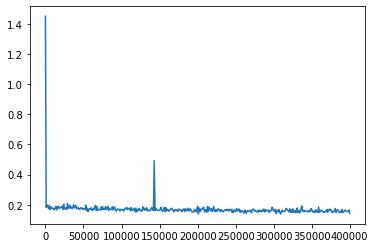

In [14]:
plt.plot([1000*i for i in range(len(loss_array))],loss_array)
plt.show()

In [15]:
EIs_array=np.array(EIs)
np.save('EIs_array_16birds_2groups_circle_REWEIGHT_1layer.npy',EIs_array)
CEs_array=np.array(CEs)
np.save('CEs_array_16birds_2groups_circle_REWEIGHT_1layer.npy',CEs_array)

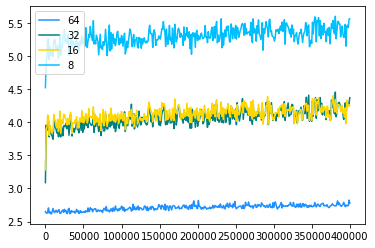

In [16]:
col1=['dodgerblue','teal','gold','deepskyblue','crimson']
EIs_array=np.array(EIs)
for i in range(EIs_array.shape[1]):
    plt.plot([1000*i for i in range(len(EIs_array))],EIs_array[0:len(EIs_array),i],label=int(64/pow(2,i)),color=col1[i])
plt.legend()
plt.show()

In [8]:
def multi_step_prediction_0(self, s, steps, level):
    if level > len(self.dynamics_modules) or level<0:
        print('input error: level must be less than', len(self.dynamics_modules))
    predicts=[]
    latents=[]
    s_hist = s
    ss = self.encoding(s)
    z_hist = ss[level]
    z = z_hist[:, :]
    predicts.append(s)
    latents.append(z)
    for t in range(steps):    
        z_next, s_next = self.simulate(z, level)
        z_hist = torch.cat((z_hist, z_next), 0)
        s_hist = torch.cat((s_hist, self.eff_predict(s_next)), 0)
        predicts.append(s_next)
        latents.append(z_next)
        z = z_next
    return predicts, latents

In [7]:
N1=8
N2=8
N =N1+N2
NS = 1
L = 10
hidden_units = 32
sigma=1
torch.manual_seed(10)
net= Parellel_Renorm_Dynamic(sym_size = 4*N, latent_size = 4*2, effect_size = 4*N, cut_size = 2, 
                     hidden_units = hidden_units, normalized_state = False, device = device)
net= net.to(device) if use_cuda else net
net.load_state_dict(torch.load('./Models_16birds_2groups/model_16birds_2groups_circle_2path_2angle_tensor_kde_4batch_4layer_reweight_REMAKE_358000.pkl',map_location=device))

level=3
steps=40
boids1 = Boids1(N1) 
boids2 = Boids2(N2) 
for origin_t in range(20):
    boids1.move()
    boids2.move()
Pos_Vec=np.vstack((np.hstack((np.array(boids1.pos),np.array(boids1.vel))),np.hstack((np.array(boids2.pos),np.array(boids2.vel)))))
Pos_Vec=torch.FloatTensor(Pos_Vec)
Pos_Vec=Pos_Vec.to(device)

Pos_Vec_predict, latents=net.multi_step_prediction_0(Pos_Vec.contiguous().view(1, 4*(N1+N2)), steps, level)

real_Pos_Vec=[]
real_Pos_Vec.append(Pos_Vec)
for t in range(steps):
    boids1.move()
    boids2.move()
    Pos_Vec=np.vstack((np.hstack((np.array(boids1.pos),np.array(boids1.vel))),np.hstack((np.array(boids2.pos),np.array(boids2.vel)))))
    Pos_Vec=torch.FloatTensor(Pos_Vec)
    Pos_Vec=Pos_Vec.to(device)
    real_Pos_Vec.append(Pos_Vec)
Pos_Vec_predict_array=np.array([Pos_Vec_predict[i].contiguous().view(1,(N1+N2),4)[0].tolist() for i in range(len(Pos_Vec_predict))])
real_Pos_Vec_array=np.array([real_Pos_Vec[i].tolist() for i in range(len(real_Pos_Vec))])
latents_array=np.array([latents[i].tolist() for i in range(len(latents))])

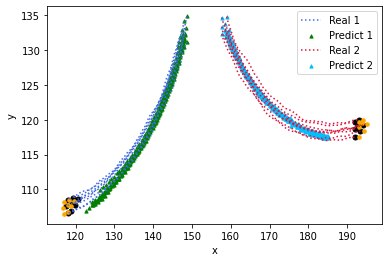

In [8]:
col=['g','deepskyblue']
col0=['royalblue','crimson']
for i in range(2):
    for j in range(N*i//2,N*(i+1)//2):
        if j<N*(i+1)//2-1:
            plt.plot(real_Pos_Vec_array[0:steps+1,j,0],real_Pos_Vec_array[0:steps+1,j,1],color=col0[i],linestyle=':')
            plt.scatter(Pos_Vec_predict_array[0:steps+1,j,0],Pos_Vec_predict_array[0:steps+1,j,1],color=col[i],marker='^',s=10)
        if j==N*(i+1)//2-1:
            plt.plot(real_Pos_Vec_array[0:steps+1,j,0],real_Pos_Vec_array[0:steps+1,j,1],color=col0[i],linestyle=':',label='Real %s'%(i+1))
            plt.scatter(Pos_Vec_predict_array[0:steps+1,j,0],Pos_Vec_predict_array[0:steps+1,j,1],color=col[i],marker='^',s=10,label='Predict %s'%(i+1))
plt.scatter(real_Pos_Vec_array[steps:steps+1,:,0],real_Pos_Vec_array[steps:steps+1,:,1],color='black',marker='.',s=100)   
plt.scatter(real_Pos_Vec_array[steps:steps+1,:,0]+real_Pos_Vec_array[steps:steps+1,:,2],
            real_Pos_Vec_array[steps:steps+1,:,1]+real_Pos_Vec_array[steps:steps+1,:,3],color='orange',marker='.',s=50)  
plt.legend()  
plt.xlabel('x',fontsize=10)      
plt.ylabel('y',fontsize=10)
plt.show()

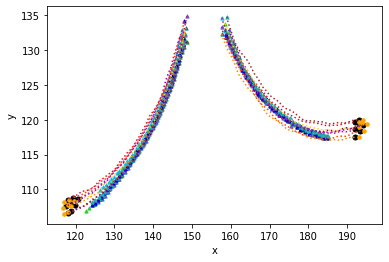

In [9]:
col=['forestgreen','deepskyblue','royalblue','teal','limegreen','slateblue','mediumblue','lightseagreen','forestgreen','deepskyblue','royalblue','teal','limegreen','slateblue','mediumblue','lightseagreen']
col0=['purple','crimson','darkviolet','darkorange','gold','mediumvioletred','orangered','brown','purple','crimson','darkviolet','darkorange','gold','mediumvioletred','orangered','brown']
for j in range(16):
    plt.plot(real_Pos_Vec_array[0:steps+1,j,0],real_Pos_Vec_array[0:steps+1,j,1],color=col0[j],linestyle=':',label='Real %s'%(j+1))
    plt.scatter(Pos_Vec_predict_array[0:steps+1,j,0],Pos_Vec_predict_array[0:steps+1,j,1],color=col[j],marker='^',s=10,label='Predict %s'%(j+1))
plt.scatter(real_Pos_Vec_array[steps:steps+1,:,0],real_Pos_Vec_array[steps:steps+1,:,1],color='black',marker='.',s=100)   
plt.scatter(real_Pos_Vec_array[steps:steps+1,:,0]+real_Pos_Vec_array[steps:steps+1,:,2],
            real_Pos_Vec_array[steps:steps+1,:,1]+real_Pos_Vec_array[steps:steps+1,:,3],color='orange',marker='.',s=50)   
#plt.legend(fontsize=7)
plt.xlabel('x',fontsize=10)      
plt.ylabel('y',fontsize=10)
plt.show()

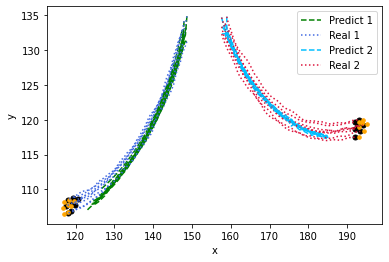

In [10]:
col=['g','deepskyblue']
col0=['royalblue','crimson']
for i in range(2):
    for j in range(N*i//2,N*(i+1)//2):
        if j<N*(i+1)//2-1:
            plt.plot(Pos_Vec_predict_array[0:steps+1,j,0],Pos_Vec_predict_array[0:steps+1,j,1],linestyle='--',color=col[i])
            plt.plot(real_Pos_Vec_array[0:steps+1,j,0],real_Pos_Vec_array[0:steps+1,j,1],linestyle=':',color=col0[i])
            
        if j==N*(i+1)//2-1:
            plt.plot(Pos_Vec_predict_array[0:steps+1,j,0],Pos_Vec_predict_array[0:steps+1,j,1],color=col[i],linestyle='--',label='Predict %s'%(i+1))
            plt.plot(real_Pos_Vec_array[0:steps+1,j,0],real_Pos_Vec_array[0:steps+1,j,1],linestyle=':',color=col0[i],label='Real %s'%(i+1))
            
plt.scatter(real_Pos_Vec_array[steps:steps+1,:,0],real_Pos_Vec_array[steps:steps+1,:,1],color='black',marker='.',s=100)   
plt.scatter(real_Pos_Vec_array[steps:steps+1,:,0]+real_Pos_Vec_array[steps:steps+1,:,2],
            real_Pos_Vec_array[steps:steps+1,:,1]+real_Pos_Vec_array[steps:steps+1,:,3],color='orange',marker='.',s=50)          
plt.legend()
plt.xlabel('x',fontsize=10)      
plt.ylabel('y',fontsize=10)
plt.show()

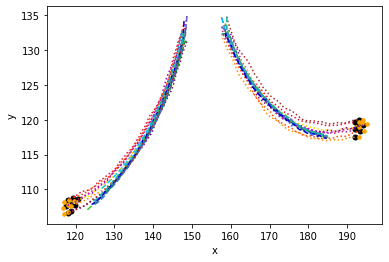

In [11]:
col=['forestgreen','deepskyblue','royalblue','teal','limegreen','slateblue','mediumblue','lightseagreen','forestgreen','deepskyblue','royalblue','teal','limegreen','slateblue','mediumblue','lightseagreen']
col0=['purple','crimson','darkviolet','darkorange','gold','mediumvioletred','orangered','brown','purple','crimson','darkviolet','darkorange','gold','mediumvioletred','orangered','brown']
for j in range(16):
    plt.plot(real_Pos_Vec_array[0:steps+1,j,0],real_Pos_Vec_array[0:steps+1,j,1],color=col0[j],linestyle=':',label='Real %s'%(j+1))
    plt.plot(Pos_Vec_predict_array[0:steps+1,j,0],Pos_Vec_predict_array[0:steps+1,j,1],linestyle='--',color=col[j],label='Predict %s'%(j+1))
plt.scatter(real_Pos_Vec_array[steps:steps+1,:,0],real_Pos_Vec_array[steps:steps+1,:,1],color='black',marker='.',s=100)   
plt.scatter(real_Pos_Vec_array[steps:steps+1,:,0]+real_Pos_Vec_array[steps:steps+1,:,2],
            real_Pos_Vec_array[steps:steps+1,:,1]+real_Pos_Vec_array[steps:steps+1,:,3],color='orange',marker='.',s=50)   
#plt.legend(fontsize=7)
plt.xlabel('x',fontsize=10)      
plt.ylabel('y',fontsize=10)
plt.show()

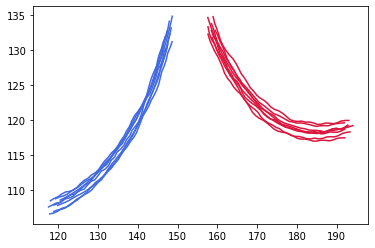

In [12]:
col=['g','deepskyblue']
col0=['royalblue','crimson']
for i in range(2):
    for j in range(N*i//2,N*(i+1)//2):
        plt.plot(real_Pos_Vec_array[0:steps+1,j,0],real_Pos_Vec_array[0:steps+1,j,1],color=col0[i],label='Real %s'%(j+1))
        #plt.plot(real_Pos_Vec_array[0:5,j,0],real_Pos_Vec_array[0:5,j,1],color='crimson')
#for j in range(2):
    #plt.plot(latents_array[0:steps+1,0,j],latents_array[0:steps+1,1,j],linestyle='--',label='Latent',color='purple')
#plt.legend()
plt.show()